In [1]:
# Import relevant modules
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.image as mpimg
from scipy.stats import kde, spearmanr
from scipy.optimize import curve_fit

from time import perf_counter # ref


In [2]:
mechanismIndex = 0 # 0-5
subIndex = 3

# Thresholds and cutoffs
phenotypeThreshold = 1e-1
residualCutoff = 0.8

meshLength = 25

In [3]:
geneIndexTranslation = {
    0 : 'r',
    1 : 'b',
    2 : 'g'
}

In [4]:
mechanisms = np.load('mechanisms.npy')

numOfDistances = (9,1,2,2,0,2)[mechanismIndex]

In [5]:
# Mechanism
interactionWeights = mechanisms[subIndex,mechanismIndex]


In [6]:
def calculateTraitField(traitHistories:np.ndarray, initialPhenotypes:np.ndarray,
                        units:np.ndarray, position_aim:float=None,
                        width_aim:float=None) -> (np.ndarray,
                                                np.ndarray,
                                                np.ndarray,
                                                np.ndarray):
    """
    Generates the vector field arrays for the phenotypes in the phenotype space.
    
    Inputs:
        - traitHistory:np.ndarray: The history of the widths and positions of the stripes.
        - units:np.ndarray: Units of threshold in both phenotype directions.
        - position_aim:float=None: The position to select for.
        - width_aim:float=None: The width to select for.
        
    Outputs:
        - X:np.ndarray: Coordinates of the positions being sampled.
        - Y:np.ndarray: Coordinates of the widths being sampled.
        - U:np.ndarray: Average position differences.
        - V:np.ndarray: Average width differences.
    """
    
    # Finds the maximum and minimum positions and widths.
    domain = list(map(lambda x: x[:,0]!=-1, traitHistories))
    extrema = np.transpose([np.min(traitHistories[domain], axis=0), np.max(traitHistories[domain], axis=0)])
    
    # Creates the sample points
    x = np.linspace(extrema[0,0], extrema[0,1], meshLength)
    y = np.linspace(extrema[1,0], extrema[1,1], meshLength)
    
    x2D, y2D = np.meshgrid(x, y)
    
    traitDifferences = np.zeros((len(traitHistories), int(max(numOfMutations))-1, 2))

    
    numOfAcceptedMutations = np.sum(domain, axis=1, dtype=int)
    
    # Calculate the differences between successive phenotypes.
    for i,traitHistory in enumerate(traitHistories):
        traitDifferences[i,:numOfAcceptedMutations[i]-1] = (np.roll(traitHistory[domain[i]], -1, axis=0) 
                                                                  - traitHistory[domain[i]])[:-1]
                
    U,V = averageDifferences(x,y, traitHistories, traitDifferences, meshLength,numOfAcceptedMutations, domain)
    
    return x2D,y2D,U,V
    
    

def averageDifferences(x:np.ndarray, y:np.ndarray, traitHistories:np.ndarray, traitDifferences:np.ndarray,
                      meshLength:int, numOfAcceptedMutations:np.ndarray, domain:np.ndarray) -> (np.ndarray,
                                                                                               np.ndarray):
    """
    Determines the vector field of the average differences in phenotypes.
    
    Inputs:
        x:np.ndarray: Available positions.
        y:np.ndarray: Available widths
        traitHistories:np.ndarray: The histories of the phenotypes.
        traitDifference:np.ndarray: The differences between consecutive phenotypes.
        meshLength:int: The length of one side of the mesh.
        numOfAcceptedMutations:np.ndarray: The number of mutations which are accepted.
        domain:np.ndarray: An array of the elements which have data in them.
    
    Outputs:
        - U:np.ndarray: The average position differences.
        - V:np.ndarray: The average weight differences.
    """
    
    U = np.zeros((meshLength, meshLength))
    V = np.zeros((meshLength, meshLength))
    num = np.zeros((meshLength, meshLength), dtype=np.int32)
    

    # componentDifferences = traitHistories - x,y
    componentDifference = np.empty((2, meshLength))
        
    for i,traitHistory in enumerate(traitHistories):
        for m in range(numOfAcceptedMutations[i]-1):
            # Finds the differences in each component.
            componentDifference[0] = np.abs(traitHistory[domain[i]][m,0] - x)
            componentDifference[1] = np.abs(traitHistory[domain[i]][m,1] - y)
            
            # Minimum difference positions
            minDiff = np.min(componentDifference, axis=1)
            coord = (np.where(minDiff[1]==componentDifference[1]),
                     np.where(minDiff[0]==componentDifference[0]))

            U[coord] += traitDifferences[i,m,0]
            V[coord] += traitDifferences[i,m,1]
            num[coord] += 1
            
    # Calculate the average.
    for i in range(meshLength):
        for j in range(meshLength):
            if U[i,j]!=0:
                U[i,j] /= num[i,j]
                V[i,j] /= num[i,j]
    
    
    return U,V

In [7]:
def timeConvergenceFrequency(traitHistories:np.ndarray):
    """
    Determines how long iterations take to converge and display them in a histogram.
    
    Inputs:
        - traitHistories:np.ndarray: The histories of the phenotypes.
    """

    
    
    timesToConverge = np.asarray(list(map(lambda x: np.shape(x[x[:,0]!=-1])[0], traitHistories)))
    counts, bins = np.histogram(timesToConverge, bins=10)
    
    # Create histogram
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    
    ax.hist(bins[:-1], bins, weights=counts)
    ax.grid(axis='y')
    
    # Creates appropiate labels
    ax.set_xlabel('number of accepted mutations', fontsize=14)
    ax.set_ylabel('frequency', fontsize=14)
    
    
    plt.show(fig)


def getLabel(interactionWeights:np.ndarray, weightPosition:np.ndarray) -> str:
    """
    Maps the weights to the mechanism structure
    
    Inputs:
        - interactionWeights:np.ndarray: The weights applied from the mechanism.
        - weightPosition:np.ndarray: The indecies of the weights to transform.
    Return:
        - weightLabel:str: The label corresponding to the weights.
    """
    if interactionWeights[weightPosition[0], weightPosition[1]] < 0:
        effectType = '|'
    else:
        effectType = '>'
        
    weightLabel = (str(geneIndexTranslation[weightPosition[1]-1]) + ' --' + effectType 
                    + ' ' + str(geneIndexTranslation[weightPosition[0]]))
    
    return weightLabel

def pairwiseCorrelationAnalysis(interactionWeights:np.ndarray, weightHistories:np.ndarray, weightPositions:np.ndarray,
                               numOfWeights:int, distance:float):
    """
    Creates pairwise correlation of final interaction weights, their density and their frequency
    
    Inputs:
        - interactionWeights:np.ndarray: The initial interaction weights.
        - weightHistories:np.ndarray: History of all mutations for all runs.
        - weightPositions:np.ndarray: The positions of the weights to vary.
        - numOfWeights:int: The number of weights to vary.
        - distance:float: Distance in the phenotype space from the initial phenotype to the selected one.
    """
       
    
    # Creates pairwise correlation analysis
    fig = plt.figure(figsize=(14,12), tight_layout=True, dpi=200)
    fig.suptitle('Pairwise correlation of final interaction weights, their density' 
                 + f'\n and their frequency for an initial phenotype distance of {distance:0.3f} with Pearson (r) and\n'
                 + r'Spearman ($\rho$) correlation coefficients',
                 fontsize=20)
    # Creates an array of the final weights
    weights = np.empty((np.shape(weightHistories)[0],3,4))
    for i,weightHistory in enumerate(weightHistories):
        weights[i] = weightHistory[weightHistory[:,0,0]!=-1][-1]
        
    # Loop through all combinations of weights.
    for i in range(numOfWeights):
        for j in range(numOfWeights):
            x = weights[:, weightPositions[i,0], weightPositions[i,1]]
            y = weights[:, weightPositions[j,0], weightPositions[j,1]]
            
            ax = fig.add_subplot(numOfWeights,numOfWeights,i + numOfWeights*j + 1)
                
            # Histograms
            if i==j:
                # Displays histogram           
                counts, bins = np.histogram(weights[:,weightPositions[i,0], weightPositions[i,1]],
                                            bins=10)
                ax.hist(bins[:-1], bins, weights=counts, color='purple')

                # Creates appropiate labels
                ax.set_xlabel('final weight', color='purple', fontsize=16)
                if i!=0:
                    ax.set_ylabel('frequency', color='purple', fontsize=16)
            
            # Scatter plots
            elif i < j:
                ax.grid()
                # Displays scatter plot            
                ax.scatter(x, y, marker='.', c='g', zorder=1)
                
                
                # Determines the Pearson correlation coefficient
                x_diff = x - np.mean(x)
                y_diff = y - np.mean(y)
                residualSum = np.sum(x_diff*y_diff) / np.sqrt(np.sum(x_diff*x_diff)*np.sum(y_diff*y_diff))
                # Determines spearman correlation coefficient
                para, cvm = curve_fit(lambda z,m,c: m*z + c, x, y)
                lineY = para[0]*x + para[1]
                spearman = round(spearmanr(x,y)[0],3)
                
                
                if abs(residualSum) > residualCutoff and abs(spearman) > residualCutoff:
                    correlationAlpha = 1
                    correlationColour = 'blue'
                else:
                    correlationAlpha = 0.4
                    correlationColour = 'orange'
                    
                # Plots correlation
                ax.text(0.01,0.01, f"r = {round(residualSum,3)}",
                        transform=plt.gca().transAxes, color=correlationColour, fontsize=14)
                ax.plot(x, lineY, color=correlationColour, alpha=correlationAlpha)
                ax.text(0.01, 0.11, r'$\rho$ = ' + str(spearman),
                       transform=plt.gca().transAxes, color=correlationColour, fontsize=14) # https://www.nature.com/articles/s41598-019-57247-4.pdf
                    
            # Creates contour plots
            elif i > j:
                # [x]
                ########################
                nbins = 20


                K = kde.gaussian_kde([x, y])
                xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
                zi = K(np.vstack([xi.flatten(), yi.flatten()]))
                axesRanges = (x.min(), x.max(), y.min(), y.max())
                ratio = 0.75*(axesRanges[1] - axesRanges[0]) / (axesRanges[3] - axesRanges[2])
                

                # Creates contour plot
                im = ax.imshow(zi.reshape(xi.shape).T, cmap='Reds',
                               origin='lower', extent=axesRanges, aspect=ratio, interpolation='bicubic')
                ax.contour(xi, yi, zi.reshape(xi.shape), 4, colors='cyan', alpha=0.5, origin='lower' )
                #########################
                
            # Creates appropiate labels
            # Tick size [y]
            ax.xaxis.set_tick_params(labelsize=13)
            ax.yaxis.set_tick_params(labelsize=13)
            if i==0:

                weightLabel = getLabel(interactionWeights, weightPositions[j])
                if j==0:
                    ax.set_ylabel(weightLabel + '\nfrequency', color='purple', fontsize=16)
                else:
                    ax.set_ylabel(weightLabel, color='purple', fontsize=16)
            if j==0:
                weightLabel = getLabel(interactionWeights, weightPositions[i])
                ax.set_title(weightLabel, color='purple', fontsize=16)
                
    
    plt.show(fig)
    
    
def displayTraitHistory(traitHistories:np.ndarray, initialPhenotypes:np.ndarray,
                        units:np.ndarray, position_aim:float=None, width_aim:float=None):
    """
    Displays the traits through time.
    
    Inputs:
        - traitHistory:np.ndarray: The history of the widths and positions of the stripes.
        - units:np.ndarray: Units of threshold in both phenotype directions.
        - position_aim:float=None: The position to select for.
        - width_aim:float=None: The width to select for.
    """
    
    distance = np.hypot((initialPhenotypes[0]-position_aim)/units[0],
                        (initialPhenotypes[1]-width_aim)/units[1])
    
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    
    
    # Displays start points
    ax.scatter(initialPhenotypes[0], initialPhenotypes[1], marker='o', color='cyan', zorder=2)
    
    # Displays paths
    for i,traitHistory in enumerate(traitHistories):
        domain = traitHistory[:,0]!=-1


        
        ax.plot(traitHistory[domain][:,0],
                traitHistory[domain][:,1],
                marker='.', color='orange', alpha=0.5, zorder=1)

        ax.scatter(traitHistory[domain][-1,0],
                   traitHistory[domain][-1,1],
                   color='purple', marker='.', zorder=3)

    
    # Displays aim
    if position_aim != None and width_aim != None:
        ax.scatter(position_aim, width_aim, marker='o', color='red')
        # Creates convergence threshold circle
        angle = np.linspace(0,2*np.pi,100)
        ax.plot(position_aim + phenotypeThreshold*np.cos(angle)*units[0],
                width_aim + phenotypeThreshold*np.sin(angle)*units[1], color='red', marker=None)
    elif position_aim != None:
        ax.axvline(position_aim, color='red')
    elif width_aim != None:
        ax.axhline(width_aim, color='red')
        
        
    ax.grid()
        
    # Creates appropiate labels
    ax.set_xlabel('position / x [cell]', fontsize=14)
    ax.set_ylabel(r'width / w [$\sigma$]', fontsize=14)
    ax.set_title(f'Variation of traits after consecutive mutations with\n distance={round(distance,3)}', fontsize=14)
    
    # Custom legend # ref
    startPoint = mlines.Line2D([], [], color='cyan', marker='o', linestyle='None',
                          label='Start point')
    mutatedPoint = mlines.Line2D([], [], color='orange', marker='.', linestyle='None',
                          label='Mutated point')
    finalPoint = mlines.Line2D([], [], color='purple', marker='.', linestyle='None',
                          label='Final point')
    ax.legend(handles=[startPoint, mutatedPoint, finalPoint], loc='best')
    
    plt.show(fig)
    


    

In [8]:
position_aims = (22.5, 14.5, 18., 19., 0, 7.)
width_aims = (0.25, 1.2, 0.45, 1.3, 0, 0.22)


position_aim = position_aims[mechanismIndex]
width_aim = width_aims[mechanismIndex]


numOfReruns = 100 # min 5

averageDeviations, deviationUncertainties = np.loadtxt(f'deviations{mechanismIndex}.txt')



traitHistories = np.load(f'traitHistories{mechanismIndex}_{subIndex}.npy')
weightHistories = np.load(f'weightHistories{mechanismIndex}_{subIndex}.npy')
numOfMutations = np.load(f'numOfMutations{mechanismIndex}_{subIndex}.npy')

initialPhenotypes = traitHistories[0,0]
# Finds the positions of the weights which are varied
weightPositions = np.argwhere(interactionWeights[:,1:]!=0)
weightPositions[:,1:] += 1
numOfWeights = np.shape(weightPositions)[0] 

distance = np.hypot((initialPhenotypes[0]-position_aim)/deviationUncertainties[0],
                                (initialPhenotypes[1]-width_aim)/deviationUncertainties[1])

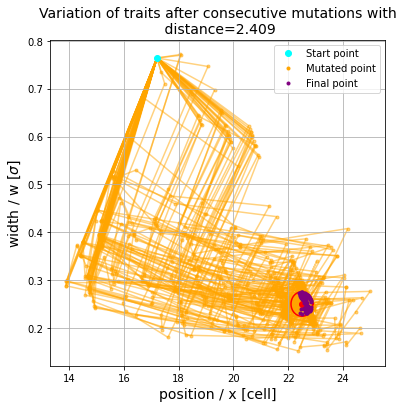

In [9]:
displayTraitHistory(traitHistories, initialPhenotypes, 
                    deviationUncertainties, position_aim=position_aim, width_aim=width_aim)

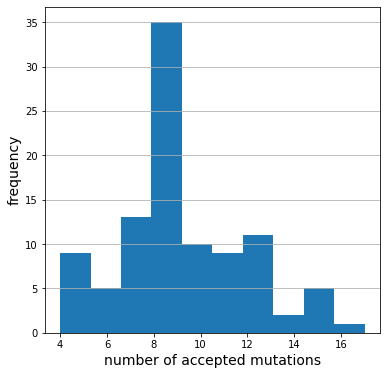

In [10]:
timeConvergenceFrequency(traitHistories)

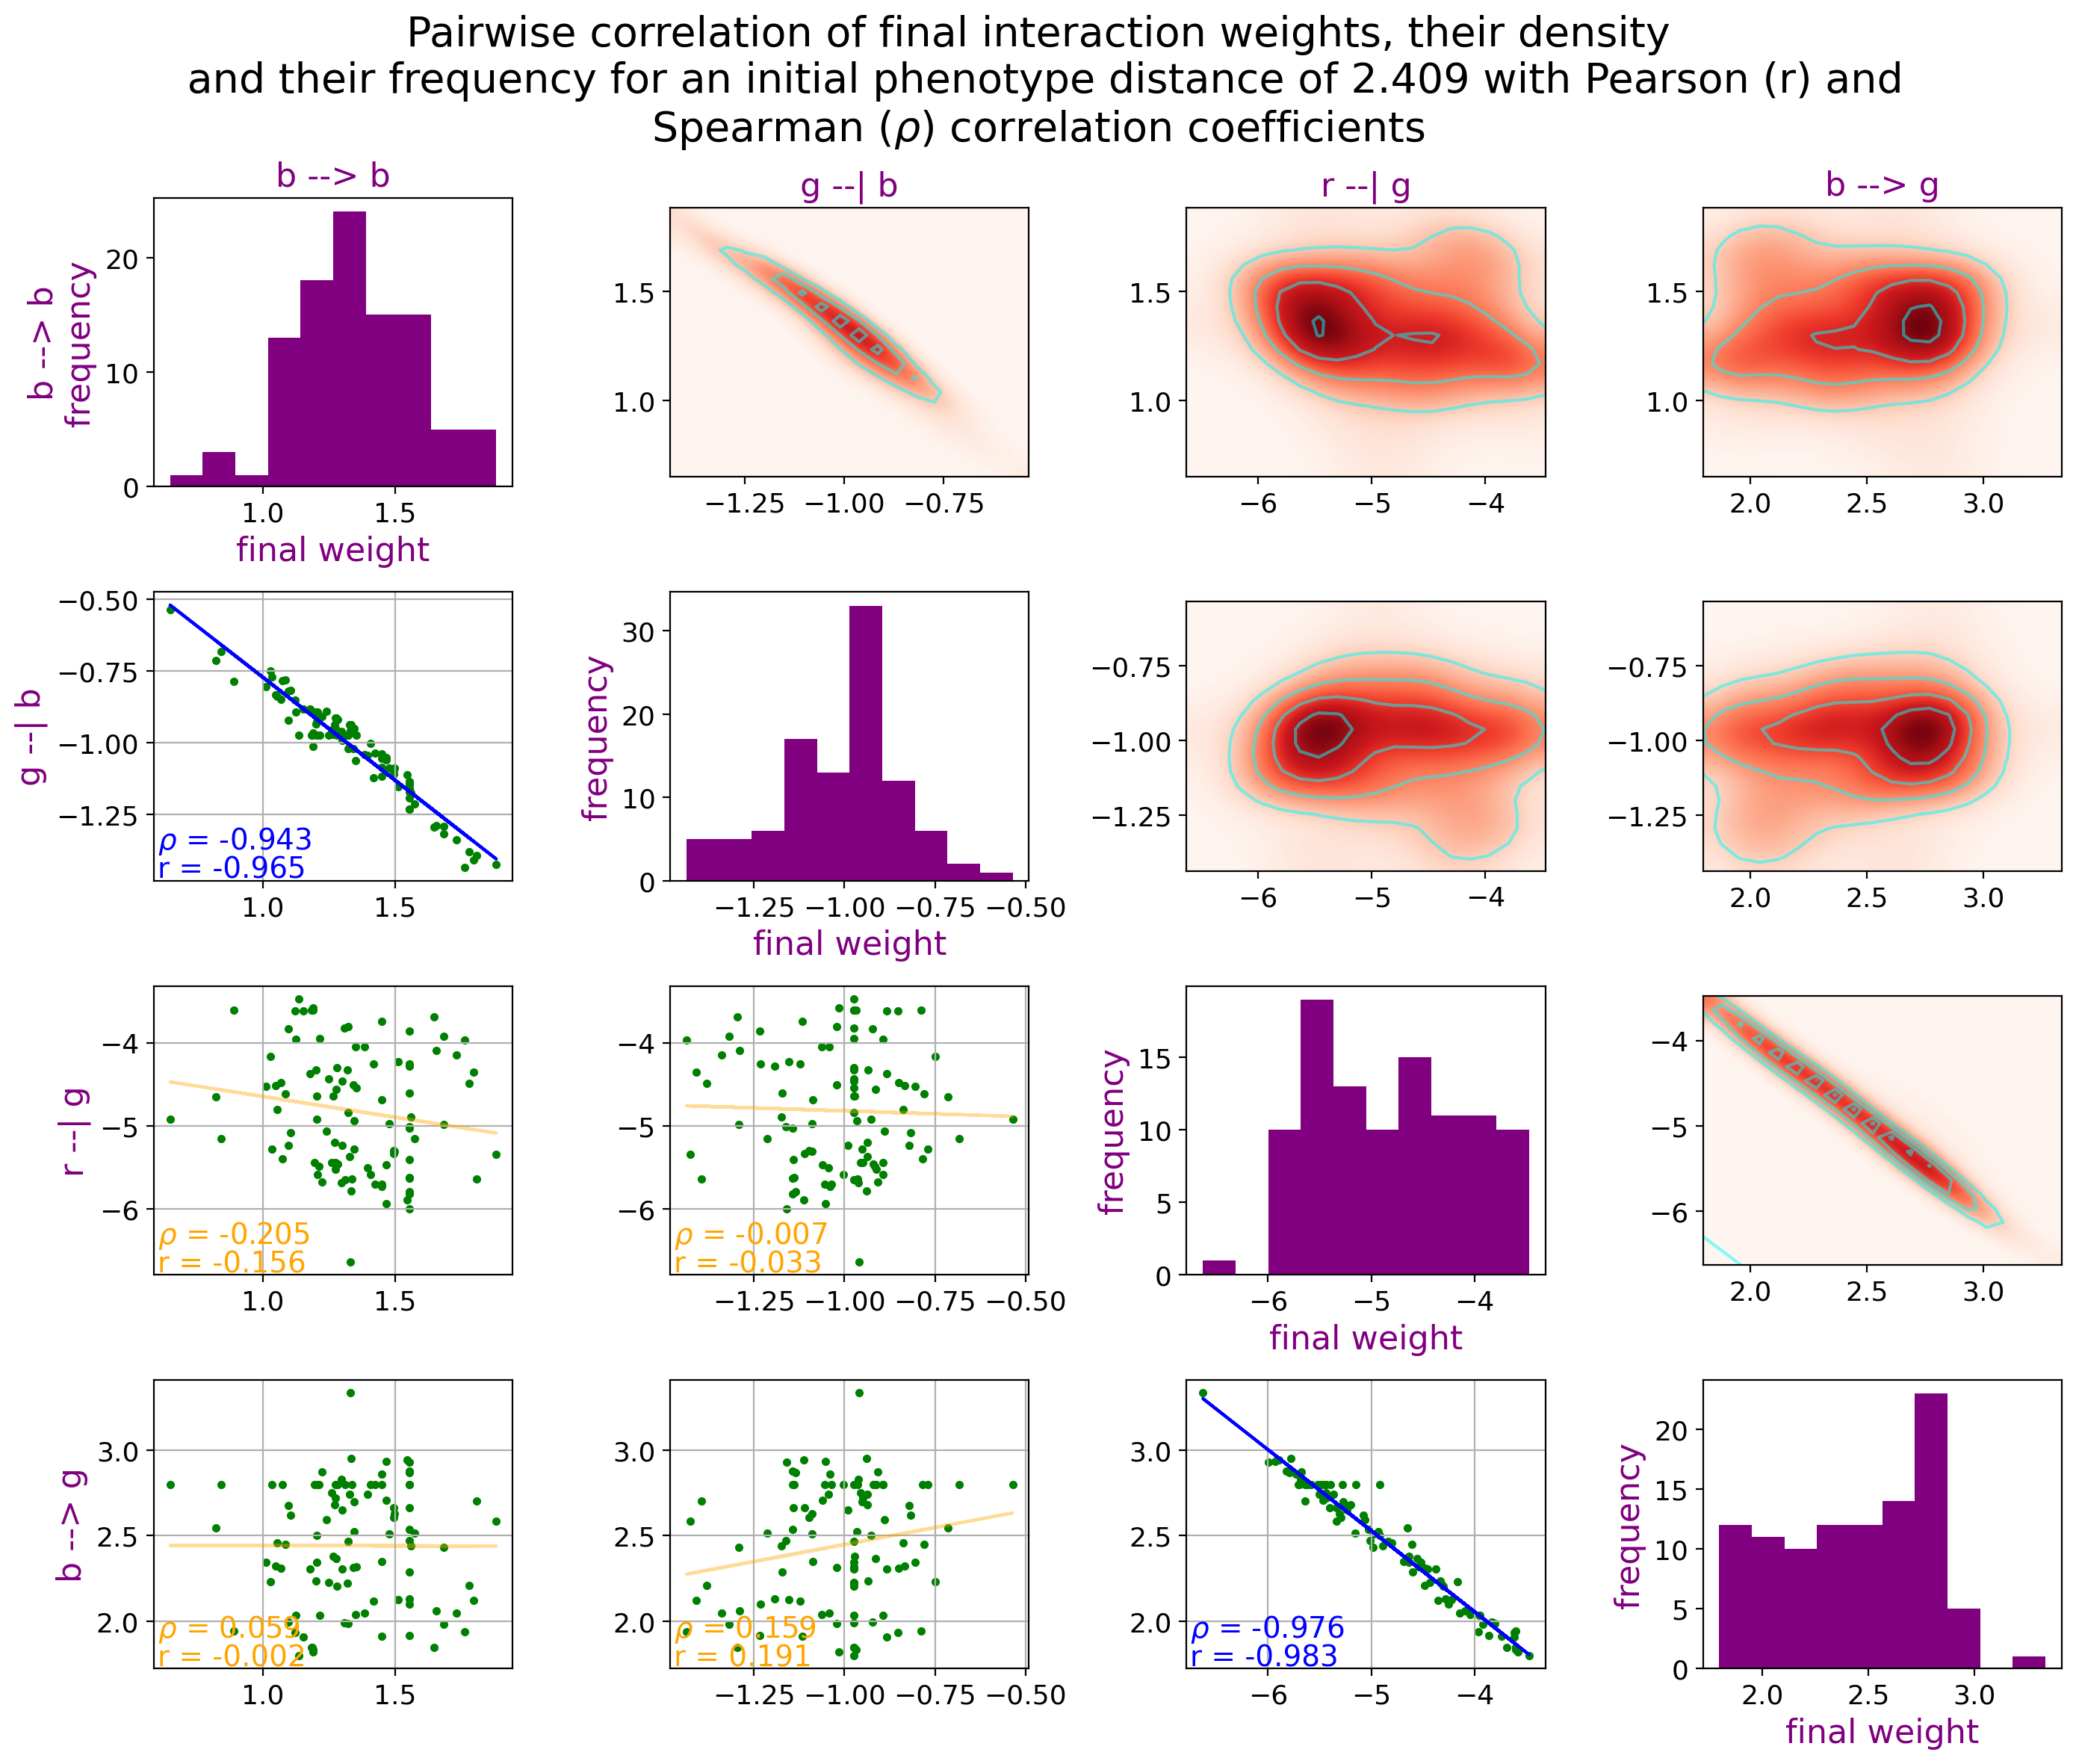

In [11]:
pairwiseCorrelationAnalysis(interactionWeights, weightHistories, weightPositions, numOfWeights, distance)

In [12]:
def distanceCorrelation(mechanismIndex:int, numOfDistances:int, weightPositions:np.ndarray, numOfWeights:int,
                       units:np.ndarray, position_aim:float, width_aim:float) -> (np.ndarray,np.ndarray,np.ndarray):
    """
    Creates data to determine if there is a correlation between distance from selected phenotype and the 
    final weight obtained.
    
    Inputs:
         - mechanismIndex:int: The mechanism to analyse.
         - numOfDistances:int: The number of samples available.
         - weightPositions:np.ndarray: Positions of the weights.
         - numOfWeights:int The number of weights to vary.
         - units:np.ndarray: Deviations of each phenotype.
         - position_aim:float: The position being selected for.
         - width_aim:float: The width being selected for.
    
    Outputs:
        - weightAverages:np.ndarray: The average weights for each distance.
        - weightStd:np.ndarray: The standard deviation of the weights for each distance.
        - distances:np.ndarray: The distances of the samples.
    """
    
    weightAverages = np.zeros((numOfWeights,numOfDistances))
    weightStd = np.empty((numOfWeights,numOfDistances))
    distances = np.empty(numOfDistances)
    
    for subIndex in range(numOfDistances):
        # Load data
        initialPhenotypes = np.load(f'traitHistories{mechanismIndex}_{subIndex}.npy')[0,0]
        weightHistories = np.load(f'weightHistories{mechanismIndex}_{subIndex}.npy')
        
        interactionWeights = mechanisms[subIndex,mechanismIndex]
        # Creates an array of the final weights
        weights = np.empty((np.shape(weightHistories)[0],3,4))
        for i,weightHistory in enumerate(weightHistories):
            weights[i] = weightHistory[weightHistory[:,0,0]!=-1][-1]
        
        # Weight statistics
        weightAverages[:,subIndex] = np.mean(weights, axis=0)[tuple(weightPositions.T)]
        weightStd[:,subIndex] = np.std(weights, axis=0)[tuple(weightPositions.T)]
        distances[subIndex] = np.hypot((initialPhenotypes[0]-position_aim)/units[0],
                                (initialPhenotypes[1]-width_aim)/units[1])
        
    return weightAverages, weightStd, distances
        
def displayDistanceCorrelation(weightAverages:np.ndarray, weightStd:np.ndarray, distances:np.ndarray,
                               weightPositions:np.ndarray, interactionWeights:np.ndarray):
    """
    Displays the average end weights against distance from start to end phenotype.
    
    Inputs:
        - weightAverages:np.ndarray: The average weights for each distance.
        - weightStd:np.ndarray: The standard deviation of the weights for each distance.
        - distances:np.ndarray: The distances of the samples.
        - weightPositions:np.ndarray: Positions of the weights.
        - interactionWeights:np.ndarray: The initial weight matrix.
    """

    
    rows = int(np.ceil(len(distances)))
    
    
    fig = plt.figure(figsize=(8,3*rows), tight_layout=True, dpi=200)
    fig.suptitle('Average end weights for different starting\n distances from the selected phenotype', y=0.99,
                fontsize=20)

        
    # Plots average end weights
    for i,weightPosition in enumerate(weightPositions):
        ax = fig.add_subplot(rows,2,i+1)
        for j,distance in enumerate(distances):
            ax.errorbar(distance, weightAverages[i,j], yerr=weightStd[i,j],
                        capsize=5, marker='x', color='blue')
            
        ax.grid() 
            
        
        # Creates appropiate labels
        weightLabel = getLabel(interactionWeights, weightPosition)
        ax.set_title(weightLabel, fontsize=16)
        ax.set_xlabel(r'distance / $\Delta P$', fontsize=16)
        ax.set_ylabel('weight amount / W', fontsize=16)
        # Tick size
        ax.xaxis.set_tick_params(labelsize=14)
        ax.yaxis.set_tick_params(labelsize=14)

    
    plt.show(fig)
    
    
def lineCorrelationComparison(mechanismIndex:int, numOfDistances:int, weightPositions:np.ndarray,
                              numOfWeights:int) -> (np.ndarray,np.ndarray,list):
    """
    Determine the mean and standard deviation of the final weights.
    
    Inputs:
         - mechanismIndex:int: The mechanism to analyse.
         - numOfDistances:int: The number of samples available.
         - weightPositions:np.ndarray: Positions of the weights.
         - numOfWeights:int The number of weights to vary.
         
    Outputs:
        - parameters:np.ndarray: The fitted parameters
        - parameter_uncertainties:np.ndarray: The uncertainty of the parameters.
        - arrayEntries:list: The non-zero entries of the array.
    """
    
    parameters = np.zeros((numOfWeights,numOfWeights,numOfDistances,2))
    parameter_uncertainties = np.zeros((numOfWeights,numOfWeights,numOfDistances,2))
    parameterEntries = []
    
    for subIndex in range(numOfDistances):
        # Load data
        weightHistories = np.load(f'weightHistories{mechanismIndex}_{subIndex}.npy')
    
        # Creates an array of the final weights
        weights = np.empty((np.shape(weightHistories)[0],3,4))
        for i,weightHistory in enumerate(weightHistories):
            weights[i] = weightHistory[weightHistory[:,0,0]!=-1][-1]


        # Loop through all combinations of weights.
        for w1 in range(numOfWeights):
            for w2 in range(w1):

                x = weights[:, weightPositions[w1,0], weightPositions[w1,1]]
                y = weights[:, weightPositions[w2,0], weightPositions[w2,1]]

                # Determines the Pearson correlation coefficient
                x_diff = x - np.mean(x)
                y_diff = y - np.mean(y)
                residualSum = np.sum(x_diff*y_diff) / np.sqrt(np.sum(x_diff*x_diff)*np.sum(y_diff*y_diff))

                if abs(residualSum) > residualCutoff:
                    para, cvm = curve_fit(lambda inputs,m,c: m*inputs + c, x, y)
                    parameters[w1,w2,subIndex] = para
                    parameter_uncertainties[w1,w2,subIndex] = np.asarray([np.sqrt(cvm[i,i]) for i in range(2)])
                    parameterEntries.append([w1,w2,subIndex])
                    
    if len(parameterEntries)==0:
        print('No significant correlations')
    
    
    
    return parameters, parameter_uncertainties, np.asarray(parameterEntries)
    
    
def displayLineCorrelation(parameters:np.ndarray, parameter_uncertainties:np.ndarray, parameterEntries:np.ndarray,
                          distances:np.ndarray, weightPositions:np.ndarray, interactionWeights:np.ndarray):
    """
    Displays the correlation between fitted parameters for different distances.
    
    Inputs:
        - parameters:np.ndarray: The fitted parameters
        - parameter_uncertainties:np.ndarray: The uncertainty of the parameters.
        - arrayEntries:list: The non-zero entries of the array.
        - distances:np.ndarray: The distances of the samples.
        - weightPositions:np.ndarray: Positions of the weights.
        - interactionWeights:np.ndarray: The initial weight matrix.
    """
    
    
    weightPairs = np.unique(parameterEntries[:,:-1], axis=0)

    fig = plt.figure(figsize=(4*len(weightPairs),3.23*len(weightPairs)), tight_layout=True, dpi=200)
    fig.suptitle('Fitted parameters for line ' + r'$W_2=mW_1+c$' + ' for\n varying distances to selected phenotype',
                fontsize=22)
    
    for i,weightPair in enumerate(weightPairs):
        for j in range(2):
            # Creates the axis
            ax = fig.add_subplot(2,len(weightPairs),i+1 + j*len(weightPairs))
            ax.grid()

            for pEnt in parameterEntries:
                # Determines if the sample had a correlation for the given weight pairs
                if all(pEnt[:-1]==weightPair):
                    pEnt_tup = tuple(pEnt)
                    ax.errorbar(distances[pEnt[-1]], parameters[pEnt_tup][j],
                                yerr=parameter_uncertainties[pEnt_tup][j], label=round(distances[pEnt[-1]],3),
                                color=('blue','green')[j], marker='x', capsize=5)
                
            # Creates appropiate labels
            # Tick size
            ax.xaxis.set_tick_params(labelsize=14)
            ax.yaxis.set_tick_params(labelsize=14)
            
            ax.set_xlabel(r'distance / $\Delta P$', fontsize=16)
            if j==0:
                ax.set_ylabel('gradient / m', fontsize=16)
                w1 = getLabel(interactionWeights, weightPositions[weightPair[0]])
                w2 = getLabel(interactionWeights, weightPositions[weightPair[1]])
                ax.set_title(w2 + ' against ' + w1, fontsize=16)
            else:
                ax.set_ylabel('intercept / c', fontsize=16)

    
 
        
    plt.show(fig)
                
        
    

In [13]:
weightAverages, weightStd, distances = distanceCorrelation(mechanismIndex, numOfDistances, weightPositions,
                                                           numOfWeights, deviationUncertainties,
                                                           position_aim, width_aim)
parameters, parameter_uncertainties, parameterEntries = lineCorrelationComparison(mechanismIndex, numOfDistances,
                                                                                  weightPositions, numOfWeights)

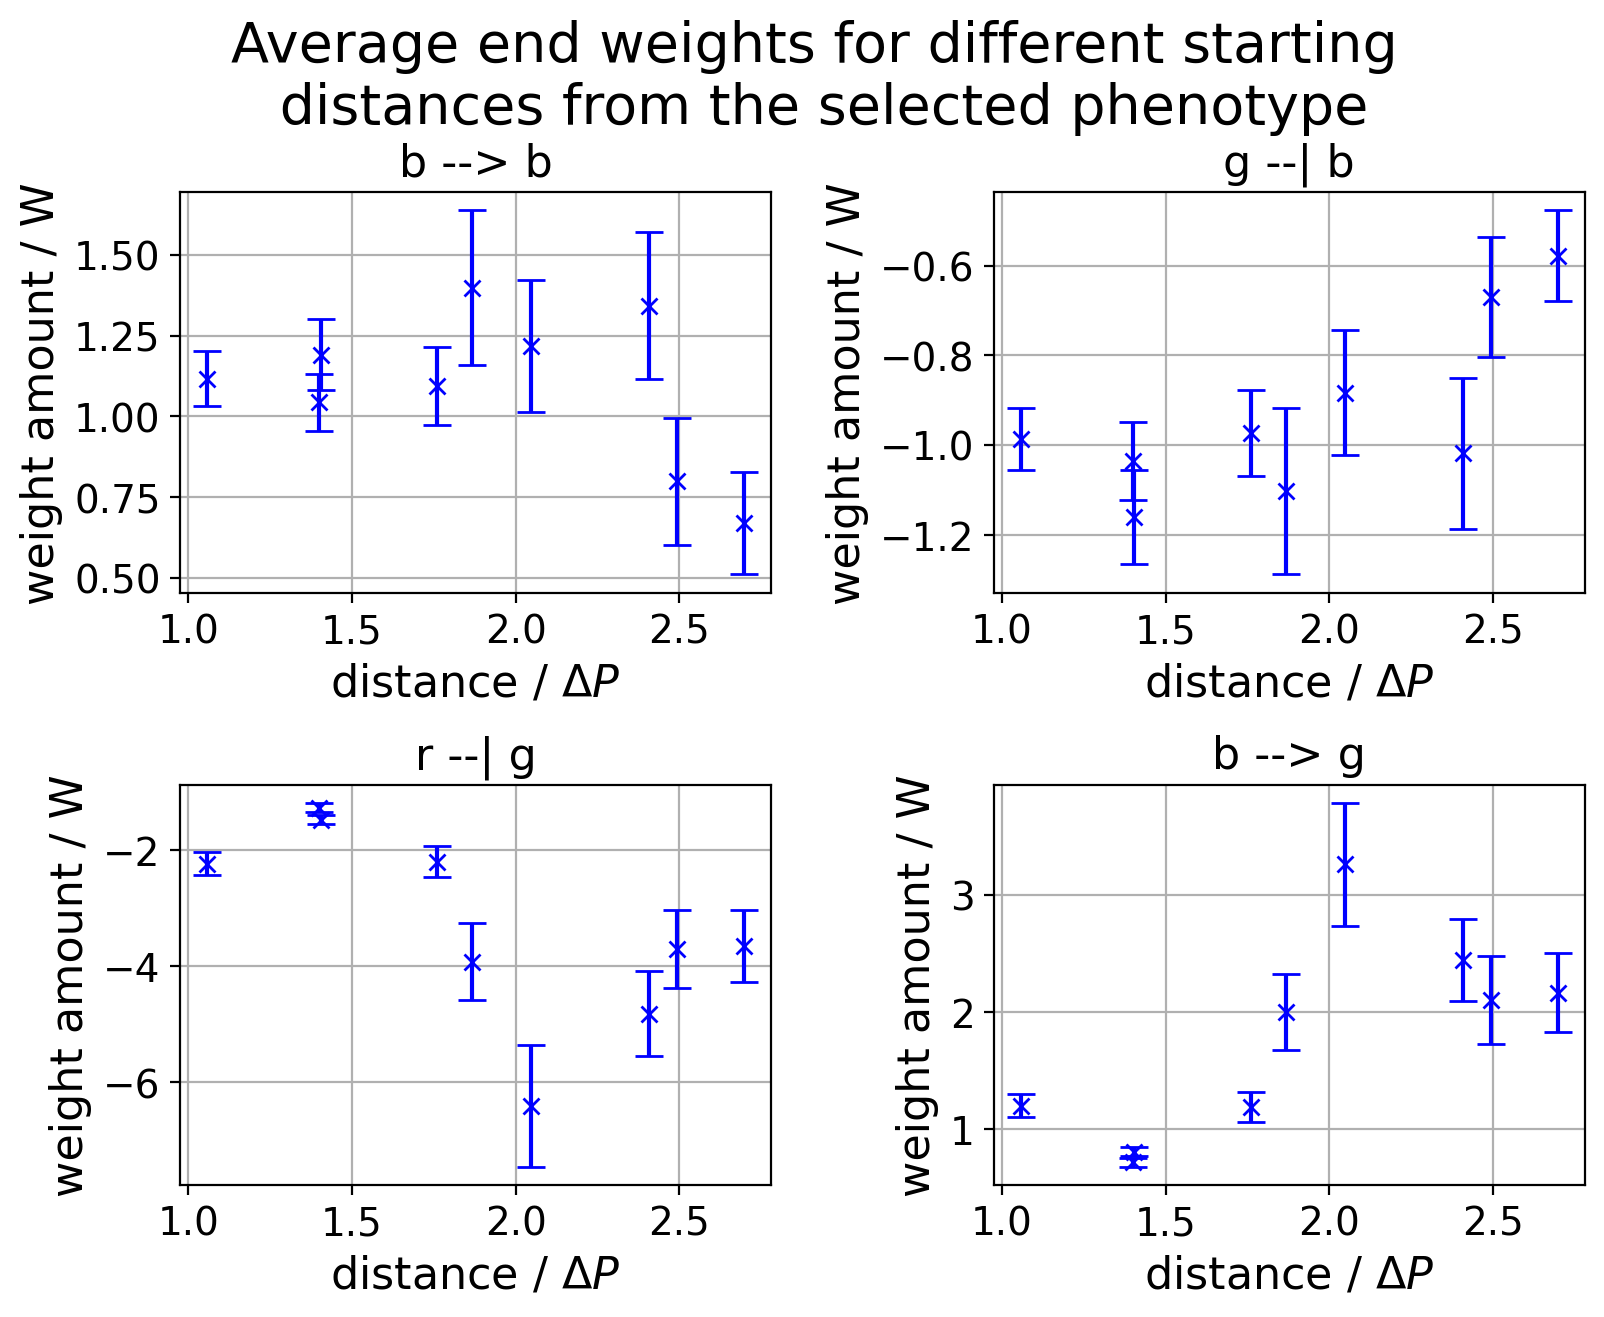

In [14]:
displayDistanceCorrelation(weightAverages, weightStd, distances, weightPositions, interactionWeights)

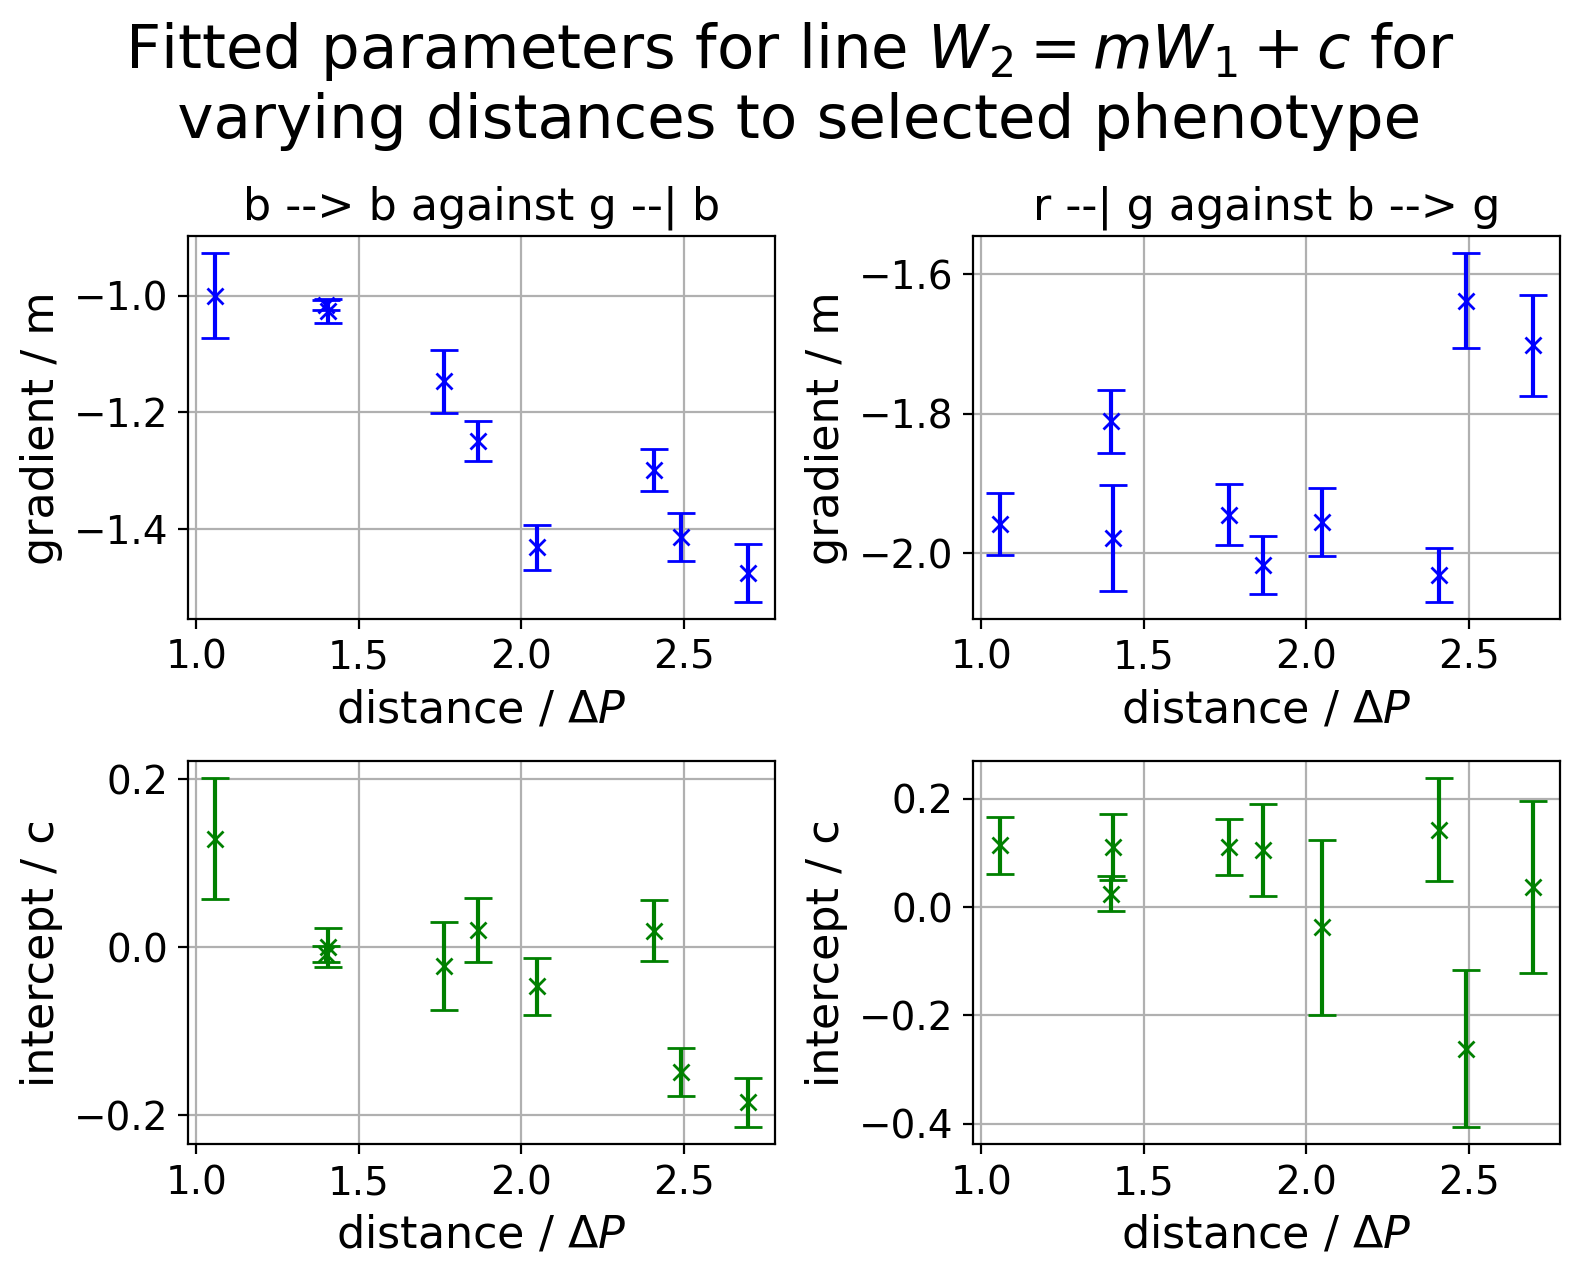

In [15]:
displayLineCorrelation(parameters, parameter_uncertainties, parameterEntries, distances, weightPositions,
                       interactionWeights)


In [16]:
def displayAllTraitFields(mechanismIndex:int, units:np.ndarray,
                         position_aim:float, width_aim:float, numOfDistances:int, distances:np.ndarray):
    """
    Calculates and displays flow diagrams for all distances sampled.
    
    Inputs:
        - mechanismIndex:int: The mechanism used.
        - units:np.ndarray: The deviations in each phenotype component.
        - position_aim:float: The position being selected for.
        - width_aim:float: The width being selected for.
        - numOfDistances:int: The number of samples.
        - distances:np.ndarray: The distances from the selected phenotype sampled.
    
    """
    
    # Setup arrays
    X = np.empty((numOfDistances, meshLength, meshLength))
    Y = np.empty_like(X)
    U = np.empty_like(X)
    V = np.empty_like(X)
    
    positionRange = position_aim*np.ones(2)
    widthRange = width_aim*np.ones(2)
    
    initialPhenotypes = np.empty((numOfDistances,2))
    boundaryOffset = 2e-1
    
    # Generate flow fields
    for subIndex in range(numOfDistances):
        # Load data
        traitHistories = np.load(f'traitHistories{mechanismIndex}_{subIndex}.npy')
        initialPhenotypes[subIndex] = np.copy(traitHistories[0,0])
    
        X[subIndex],Y[subIndex],U[subIndex],V[subIndex] = calculateTraitField(
            traitHistories, initialPhenotypes[subIndex], 
            units, position_aim=position_aim, width_aim=width_aim)
        
        # Find ranges
        if positionRange[0] > np.min(X[subIndex]):
            positionRange[0] = np.min(X[subIndex])
        if positionRange[1] < np.max(X[subIndex]):
            positionRange[1] = np.max(X[subIndex])
            
        if widthRange[0] > np.min(Y[subIndex]):
            widthRange[0] = np.min(Y[subIndex])
        if widthRange[1] < np.max(Y[subIndex]):
            widthRange[1] = np.max(Y[subIndex])
            
            
        
    # Create figure
    rows = int(np.ceil(numOfDistances/3))
    columns = 3 if numOfDistances>=3 else numOfDistances
    
    fig = plt.figure(figsize=(4*columns,4*rows), tight_layout=True, dpi=200)
    fig.suptitle('Variation of phenotypes for different initial phenotype distances       ', fontsize=20)
        
    for subIndex in range(numOfDistances):
        ax = fig.add_subplot(rows,columns,subIndex+1)
        ax.grid()
        # Displays start point
        ax.scatter(initialPhenotypes[subIndex,0], initialPhenotypes[subIndex,1], marker='o', color='cyan', zorder=2)

        # Display other start points
        for i in range(numOfDistances):
            if i != subIndex:
                ax.scatter(initialPhenotypes[i,0], initialPhenotypes[i,1], marker='.', color='lime', zorder=2)
        
        
        # Display streams
        distanceToAim = np.hypot(abs(X[subIndex]-position_aim)/units[0],abs(Y[subIndex]-width_aim)/units[1])
        streamlines = ax.streamplot(X[subIndex],Y[subIndex],U[subIndex],V[subIndex], density=0.7, 
                      zorder=1, color=distanceToAim, cmap='autumn', arrowsize=0.7, linewidth=1, arrowstyle='->')
        # Display vector field
        ax.quiver(X[subIndex],Y[subIndex],U[subIndex]*units[1],V[subIndex]*units[0], color='purple',
                  scale=2e+1, pivot='mid', zorder=1, alpha=0.9)
        
        # Displays aim
        if position_aim != None and width_aim != None:
            ax.scatter(position_aim, width_aim, marker='o', color='red')
            # Creates convergence threshold circle
            angle = np.linspace(0,2*np.pi,100)
            ax.plot(position_aim + phenotypeThreshold*np.cos(angle)*units[0],
                    width_aim + phenotypeThreshold*np.sin(angle)*units[1], color='red', marker=None)
        elif position_aim != None:
            ax.axvline(position_aim, color='red')
        elif width_aim != None:
            ax.axhline(width_aim, color='red')


        # Creates appropiate labels
        ax.set_xlabel('position / x [cell]', fontsize=14)
        ax.set_ylabel(r'width / w [$\sigma$]', fontsize=14)
        ax.set_title(f'distance={round(distances[subIndex],3)}', fontsize=14)

        ax.set_xlim(positionRange[0] - boundaryOffset*units[0], positionRange[1] + boundaryOffset*units[0])
        ax.set_ylim(widthRange[0] - boundaryOffset*units[1], widthRange[1] + boundaryOffset*units[1])
        

    startPoint = mlines.Line2D([], [], color='cyan', marker='o', linestyle='None',
                          label='Start point')
    otherStartPoints = mlines.Line2D([], [], color='lime', marker='.', linestyle='None',
                          label='Other start point')
    selectedPoint = mlines.Line2D([], [], color='red', marker='o', linestyle='None',
                          label='Selected point')
    fig.legend(handles=[startPoint, otherStartPoints, selectedPoint], loc=(0.86,0.945))
    
    plt.show(fig)
    
    

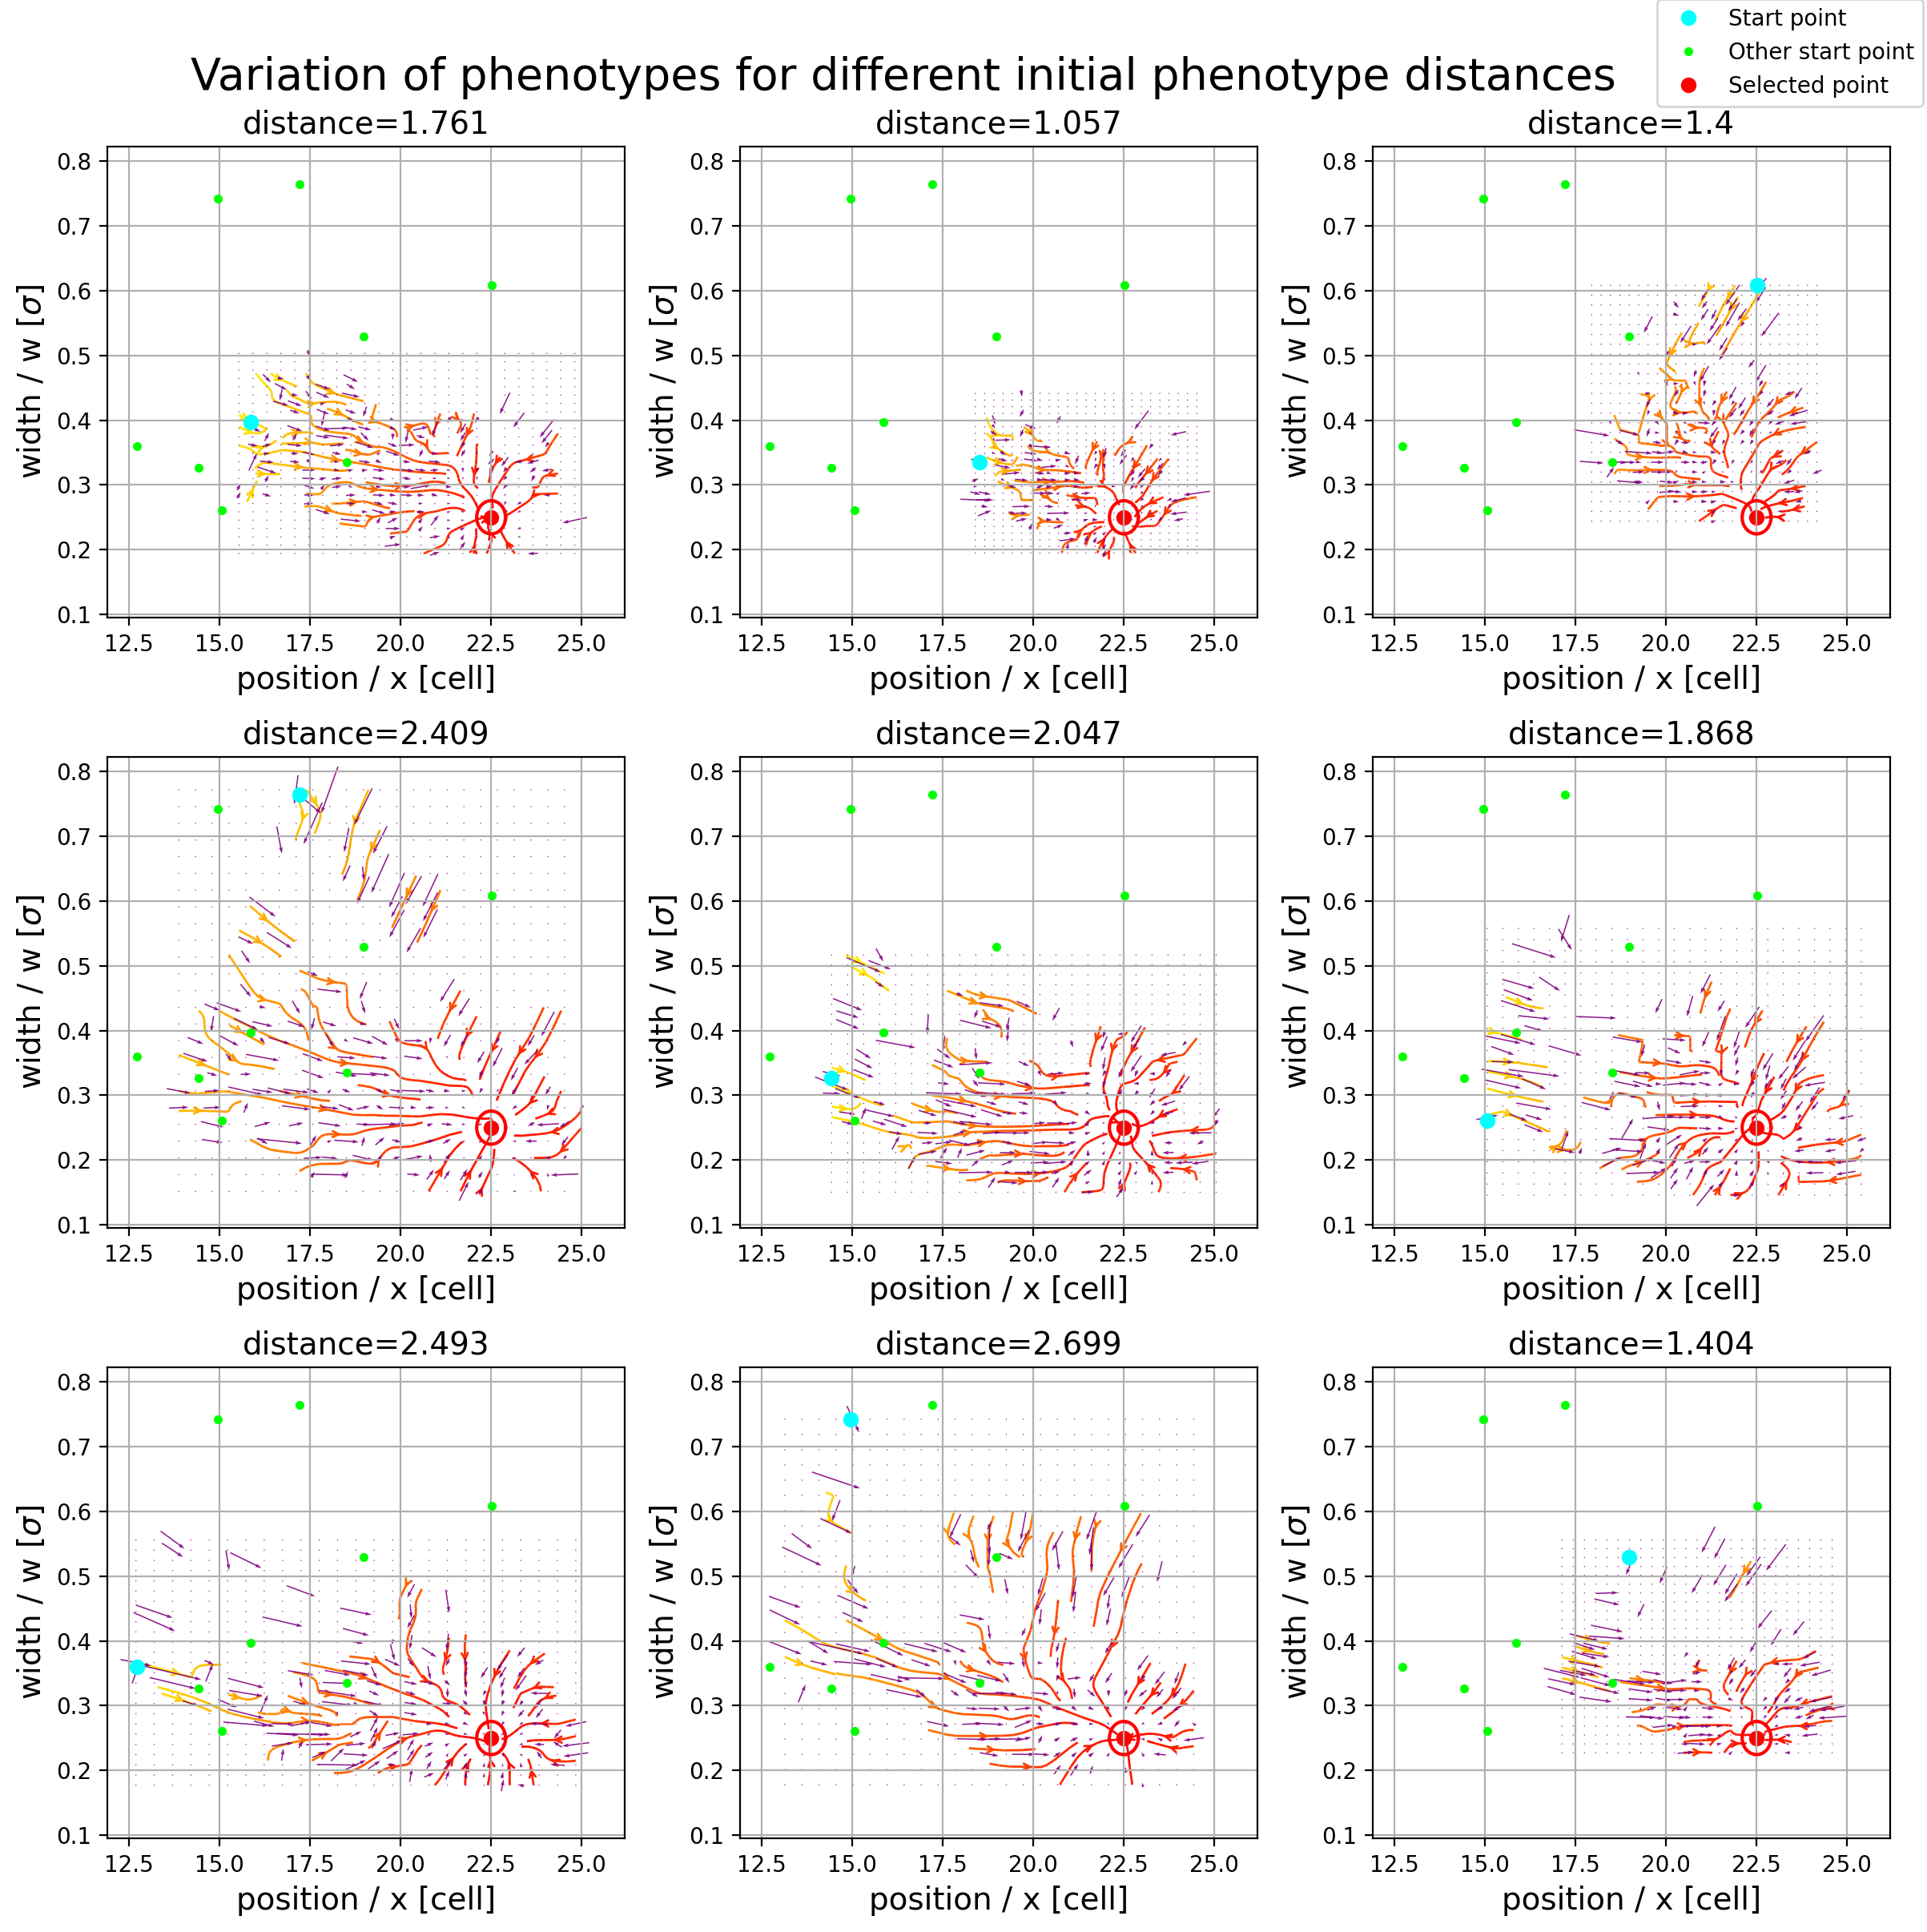

In [17]:
displayAllTraitFields(mechanismIndex, deviationUncertainties,
                         position_aim, width_aim, numOfDistances, distances)

x. Holtz, Y., 2022. [online] Python-graph-gallery.com. Available at: <https://python-graph-gallery.com/86-avoid-overlapping-in-scatterplot-with-2d-density/> [Accessed 22 July 2022].

y. https://stackoverflow.com/questions/6390393/matplotlib-make-tick-labels-font-size-smaller